# Intrinsic Gaussian CAR model
CARモデルのPyMC3実装を参考にして, Intrinsic Gaussian CARモデルを実装する.   
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

参考文献:
Exact sparse CAR models in Stan. Max Joseph. August 20, 2016  
https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html

de oliveira, Victor. (2012). Bayesian analysis of conditional autoregressive models. Annals of the Institute of Statistical Mathematics. 64. 107-133. 10.1007/s10463-010-0298-1.   
https://www.ism.ac.jp/editsec/aism/pdf/10463_2010_Article_298.pdf

Intrinsic Gaussian CAR model:
\begin{align}
y_i \mid \{y_j : j \neq i\} \sim \text{Normal}(\alpha\Sigma_{j\neq i} b_{ij}y_j, \tau_i^{-1}).
\end{align}
ここで, $y_i$ は観測データ, $B=(b_{ij})$ は scaled adjacency matrix.
$m_i=i$の近傍場所数とし、$D=(\text{diag}(m_i)), \ W=(w_{ij})$ を $w_{ii}=0$, $i$ と $j$が隣接していたら $w_{ij}=1$, 隣接していなければ $w_{ij}=0$を満たすような adjacency matrix とすると, $B=D^{-1}W$ である.

同時分布は
\begin{align}
y \sim \text{Normal}(0, [\tau (D - \alpha W)]^{-1}).
\end{align}
で与えられる.

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
import ForneyLab.dot2svg
using LinearAlgebra
@everywhere using Mamba
using Plots
using Statistics
using StatsBase

## Lip cancer risk data
まずは同様にScotlandのLip cancer risk dataを準備する. 元データは  
Kemp I. (1989) Scottish Cancer Incidence Atlas 1985. In: Boyle P., Muir C.S., Grundmann E. (eds) Cancer Mapping. Recent Results in Cancer Research, vol 114. Springer, Berlin, Heidelberg

Lip cancer rates $O_i$ は AFF (population employed in agriculture, fishing, or forestry) $a_i$, 場所差パラメーター $\phi_i$, expected rates $E$ を用いて
\begin{align}
O_i &\sim \text{Poisson}(\lambda_i), \\
\log \lambda_i & = \beta_0 + \beta_1 a_i + \phi_i + \log E_i
\end{align}
と表される. 

In [3]:
# observed
observed =
    [ 9, 39, 11, 9, 15,  8, 26,  7,  6, 20, 
     13,  5,  3, 8, 17,  9,  2,  7,  9,  7, 
     16, 31, 11, 7, 19, 15,  7, 10, 16, 11,
      5,  3,  7, 8, 11,  9, 11,  8,  6,  4,
     10,  8,  2, 6, 19,  3,  2,  3, 28,  6,
      1,  1,  1, 1,  0,  0]
# expected rates
expected =
    [ 1.4,  8.7, 3.0,  2.5,  4.3,  2.4,  8.1, 2.3,  2.0,  6.6,
      4.4,  1.8, 1.1,  3.3,  7.8,  4.6,  1.1, 4.2,  5.5,  4.4,
     10.5, 22.7, 8.8,  5.6, 15.5, 12.5,  6.0, 9.0, 14.4, 10.2,
      4.8,  2.9, 7.0,  8.5, 12.3, 10.1, 12.7, 9.4,  7.2,  5.3,
     18.8, 15.8, 4.3, 14.6, 50.7,  8.2,  5.6, 9.3, 88.7, 19.6, 
      3.4,  3.6, 5.7,  7.0,  4.2,  1.8]
#  AFF (population employed in agriculture, fishing, or forestry)
aff = 
   [16, 16, 10, 24, 10, 24, 10, 7,  7, 16,
     7, 16, 10, 24,  7, 16, 10, 7,  7, 10,
     7, 16, 10,  7,  1,  1,  7, 7, 10, 10,
     7, 24, 10,  7,  7,  0, 10, 1, 16,  0,
     1, 16, 16,  0,  1,  7,  1, 1,  0,  1,
     1, 0, 1, 1, 16, 10] ./ 10;
#  Spatial adjacency information
adj = 
    [[5, 9, 11,19],
    [7, 10],
    [6, 12],
    [18,20,28],
    [1, 11,12,13,19],
    [3, 8],
    [2, 10,13,16,17],
    [6],
    [1, 11,17,19,23,29],
    [2, 7, 16,22],
    [1, 5, 9, 12],
    [3, 5, 11],
    [5, 7, 17,19],
    [31,32,35],
    [25,29,50],
    [7, 10,17,21,22,29],
    [7, 9, 13,16,19,29],
    [4, 20, 28,33,55,56],
    [1, 5, 9, 13,17],
    [4, 18,55],
    [16,29,50],
    [10,16],
    [9, 29,34,36,37,39],
    [27,30,31,44,47,48,55,56],
    [15,26,29],
    [25,29,42,43],
    [24,31,32,55],
    [4, 18,33,45],
    [9, 15,16,17,21,23,25,26,34,43,50],
    [24,38,42,44,45,56],
    [14,24,27,32,35,46,47],
    [14,27,31,35],
    [18,28,45,56],
    [23,29,39,40,42,43,51,52,54],
    [14,31,32,37,46],
    [23,37,39,41],
    [23,35,36,41,46],
    [30,42,44,49,51,54],
    [23,34,36,40,41],
    [34,39,41,49,52],
    [36,37,39,40,46,49,53],
    [26,30,34,38,43,51],
    [26,29,34,42],
    [24,30,38,48,49],
    [28,30,33,56],
    [31,35,37,41,47,53],
    [24,31,46,48,49,53],
    [24,44,47,49],
    [38,40,41,44,47,48,52,53,54],
    [15,21,29],
    [34,38,42,54],
    [34,40,49,54],
    [41,46,47,49],
    [34,38,49,51,52],
    [18,20,24,27,56],
    [18,24,30,33,45,55]];

In [4]:
N = length(observed)

56

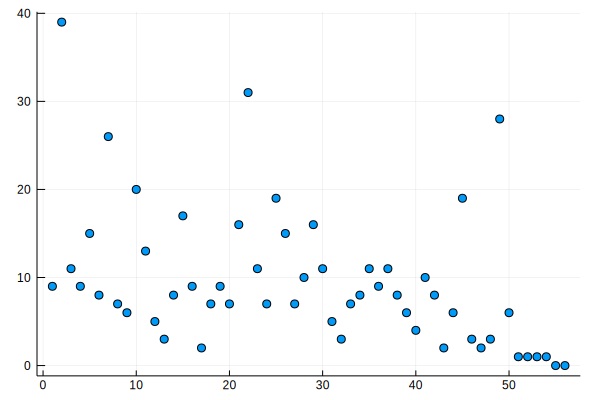

In [5]:
scatter(1:N, observed, label = "")

### 空間統計モデルの定義

In [6]:
car_model = Model(
    beta0 = Stochastic(() -> Normal()),
    beta1 = Stochastic(() -> Normal()),
    
    tau = Stochastic(() -> Gamma(2.0, 0.5)),
    alpha = Stochastic(() -> Uniform()),
    phi = Stochastic(1,
        (tau, alpha, N, D, W) -> MvNormalCanon(zeros(N), tau * (D - alpha * W)),
    ),
    
    mu = Logical(1, 
        (beta0, beta1, zscore_aff, phi, log_offset) -> 
            @.(exp(beta0 + beta1 * zscore_aff + phi + log_offset))
    ),
    
    y = Stochastic(1,
        (mu, N) -> UnivariateDistribution[Poisson(mu[i]) for i in 1:N],
        false
    )
)

Object of type "Model"
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
phi:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStoch

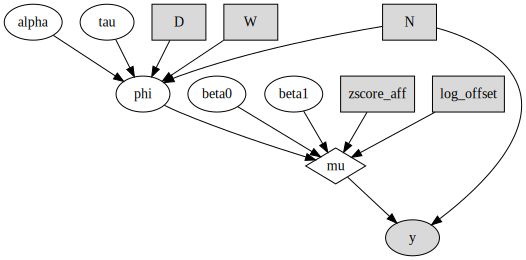

In [7]:
display("image/svg+xml", dot2svg(graph2dot(car_model)))

## データの準備

$D=(\text{diag}(m_i)):$

In [8]:
D = Diagonal(length.(adj))

56×56 Diagonal{Int64,Array{Int64,1}}:
 4  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  3  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  6  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  3  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Spatial adjacency informationを行列に展開する

In [9]:
W = zeros(Int64, N, N)
for (i, a) in enumerate(adj)
   W[i, a] .= 1 
end
W

56×56 Array{Int64,2}:
 0  0  0  0  1  0  0  0  1  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  1  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  1  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  0  0  0  1  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  1  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0  0  0  0    

In [10]:
log_offset = log.(expected)
zscore_aff = zscore(aff)
car_data = Dict{Symbol, Any}(
    :log_offset => log_offset,
    :zscore_aff => zscore_aff,
    :N => N,
    :D => D,
    :W => W,
    :y => observed
)

Dict{Symbol,Any} with 6 entries:
  :N          => 56
  :y          => [9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1…
  :D          => [4 0 … 0 0; 0 2 … 0 0; … ; 0 0 … 5 0; 0 0 … 0 6]
  :W          => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0]
  :log_offset => [0.336472, 2.16332, 1.09861, 0.916291, 1.45862, 0.875469, 2.09…
  :zscore_aff => [1.07564, 1.07564, 0.196285, 2.24812, 0.196285, 2.24812, 0.196…

初期値の設定

In [11]:
car_inits = [
    Dict{Symbol, Any}(
        :beta0 => 0.0,
        :beta1 => 0.0,
        :tau => 0.5,
        :alpha => 0.5,
        :phi => rand(Normal(), N),
        :mu => observed,
        :y => observed,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:phi=>[1.57709, 0.0189076, -0.878214, -0.203074, -0.401441, 0.583938, 0.0902967, -0.121352, 0.989021, -0.875013  …  -0.346517, -0.738877, 2.02522, -1.8677, -0.106998, -0.966673, -0.825078, 0.0728439, 0.956223, 1.49914],:tau=>0.5,:beta1=>0.0)
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:phi=>[-0.584298, -0.752457, 0.397718, 0.149564, 0.559618, 0.43092, -0.0178558, -0.653077, 0.314738, -0.0250903  …  1.51549, 1.08589, 0.545823, -0.536357, -1.53347, 0.148348, 0.055197, -0.280417, 0.460567, 1.04118],:tau=>0.5,:beta1=>0.0)    
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 

## サンプリング

In [12]:
car_scheme = [
    AMWG([:alpha, :beta0], 1.0), 
    AMWG([:beta1, :phi], 0.1), 
    Slice(:tau, 10.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:alpha, :beta0]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:beta1, :phi]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│ 

In [13]:
setsamplers!(car_model, car_scheme)
car_sim = mcmc(car_model, car_data, car_inits, 25000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 25000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [3:41:02 of 3:41:08 remaining]
      From worker 4:	Chain 2:   0% [3:43:58 of 3:44:04 remaining]
      From worker 3:	Chain 3:   0% [3:41:47 of 3:41:52 remaining]
      From worker 2:	Chain 1:  10% [0:02:34 of 0:02:51 remaining]
      From worker 4:	Chain 2:  10% [0:02:34 of 0:02:51 remaining]
      From worker 3:	Chain 3:  10% [0:02:33 of 0:02:50 remaining]
      From worker 2:	Chain 1:  20% [0:01:54 of 0:02:23 remaining]
      From worker 4:	Chain 2:  20% [0:01:55 of 0:02:24 remaining]
      From worker 3:	Chain 3:  20% [0:01:54 of 0:02:23 remaining]
      From worker 3:	Chain 3:  30% [0:01:35 of 0:02:16 remaining]
      From worker 2:	Chain 1:  30% [0:01:36 of 0:02:17 remaining]
      From worker 4:	Chain 2:  30% [0:01:36 of 0:02:17 remaining]
      From worker 3:	Chain 3:  40% [0:01:18 of 0:02:10 remaining]
      From worker 2:	Chain 1:  40% [0:01:19 of 0:02:12 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 5010:25000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[0.293315 1.42845 … 3.76366 1.49597; 0.281241 2.10687 … 2.45016 1.44261; … ; 0.119043 1.0655 … 4.27809 1.19493; 0.0967472 1.40412 … 3.93912 0.767582]

[0.291104 2.20091 … 6.49645 1.1414; 0.261964 1.59507 … 5.41898 1.63171; … ; 0.171012 1.20662 … 3.83178 1.32258; 0.119772 1.7211 … 2.45768 1.32211]

[0.197301 1.39593 … 1.81604 1.18638; 0.144045 1.07608 … 2.59217 1.05968; … ; 0.151358 1.49164 … 3.44346 1.04164; 0.0637083 1.37713 … 3.15802 0.937152]

## サンプリング結果を確認する

In [14]:
describe(car_sim)

Iterations = 5010:25000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
             Mean          SD       Naive SE       MCSE        ESS    
  beta1  0.2423470936 0.093534876 0.0012075301 0.002872367 1060.394227
    tau  1.4625577987 0.445137910 0.0057467057 0.008074846 2000.000000
  beta0 -0.0024534138 0.365568067 0.0047194635 0.039536967   85.492852
  alpha  0.9548642481 0.050171304 0.0006477088 0.001960071  655.189883
 phi[1]  1.2752453191 0.477422639 0.0061634998 0.040882470  136.374055
 phi[2]  1.2051270314 0.415193085 0.0053601197 0.040059806  107.419357
 phi[3]  1.1246751971 0.466803144 0.0060264027 0.040273769  134.345464
 phi[4]  0.5062715286 0.499931901 0.0064540931 0.041292878  146.578881
 phi[5]  1.0909274315 0.431716908 0.0055734413 0.040145164  115.646274
 phi[6]  0.7310448791 0.499014540 0.0064422500 0.039973458  155.841446
 phi[7]  1.0256246985 0.410758573 0.0053028704 0.040047588  105.201166
 phi[8]  1.0447306937 0.50761

phi[22] -0.797534318 -0.174293734  0.091030367  0.334978825  0.919460526
phi[23] -0.832769423 -0.159200209  0.112249917  0.369928651  0.950036238
phi[24] -1.125797728 -0.403103818 -0.131809398  0.142974006  0.700567611
phi[25] -0.481832677  0.173965033  0.449284742  0.702687993  1.264652711
phi[26] -0.671378442  0.011004118  0.290980880  0.555392133  1.096067633
phi[27] -1.043419948 -0.312715221 -0.020234181  0.275651186  0.926187457
phi[28] -0.906634853 -0.195956216  0.090813789  0.361654778  0.997487087
phi[29] -0.756886399 -0.099105470  0.142140722  0.365217408  0.953316693
phi[30] -1.125973323 -0.447195579 -0.155334827  0.106814196  0.669035302
phi[31] -1.082004979 -0.394111775 -0.107977471  0.161407117  0.786314126
phi[32] -1.269115058 -0.567174776 -0.239064867  0.070121140  0.753954948
phi[33] -1.121580432 -0.395613435 -0.113034853  0.174218101  0.801737318
phi[34] -1.149531071 -0.478655670 -0.211868379  0.051678183  0.611868383
phi[35] -1.037618347 -0.383703099 -0.114435408  0.1

## Plotting
サンプリングされた値と、分布の表示

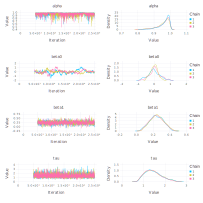

In [15]:
car_p1 = Mamba.plot(car_sim[:, [:alpha, :beta0, :beta1, :tau], :], legend = true);
Mamba.draw(car_p1, nrow = 4, ncol = 2)

自己相関と、平均の表示

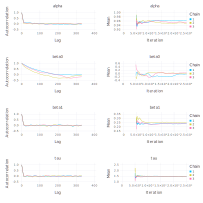

In [16]:
car_p2 = Mamba.plot(car_sim[:, [:alpha, :beta0, :beta1, :tau], :], [:autocor, :mean], legend=true);
Mamba.draw(car_p2, nrow = 4, ncol = 2)

## 95%信頼区間を求める
シミュレーションされた$\mu$を抽出し、各場所が0から100まで値をとる確率を計算する(100超の値をとることもあるが, 確率はかなり小さい)

In [17]:
sim_mu = reshape(car_sim[:, [:mu], :].value, :, N)

6000×56 Array{Float64,2}:
  5.19936   6.76774  26.6972   18.6285   …   2.58844  0.962627  2.68915 
  5.59864  10.0088   30.8891   15.434        3.9517   1.25511   2.72562 
  6.11393   5.62666  23.3127   19.1448       2.71128  0.695955  2.30268 
  4.05147   3.41629  27.2936   15.0883       1.59536  0.483186  1.33115 
 10.6313    9.12199  23.9775   11.8596       1.84863  2.34402   3.60512 
  7.02367   7.03618  26.9628   18.116    …   5.91647  1.95466   3.98203 
  8.23155   6.45298  21.5128   15.6724       3.32851  1.88781   5.02858 
  8.93307   7.06246  22.0785   18.0717       6.76618  0.496298  1.86462 
  7.35225   8.50813  22.6982   25.0636       3.07643  0.478405  1.72401 
 10.311    13.3579   28.089    12.2537       3.2917   1.4324    2.46273 
  6.66631   5.62321  22.4647   19.6921   …   5.64277  1.57961   2.2187  
  7.2215    6.72204  26.3465   24.3589       7.10714  1.21235   3.7586  
  5.9806    9.91521  24.5613   11.4783       4.22189  3.12733   2.82452 
  ⋮                      

In [18]:
prob_x = x -> mean(pdf.(Poisson.(sim_mu), x), dims = 1)
mu_prob = vcat(prob_x.(0:100)...)

101×56 Array{Float64,2}:
 0.00166866   0.00147236   0.0107713    …  0.208887     0.145704   
 0.00762742   0.00711098   0.0354217       0.288215     0.22164    
 0.0188929    0.018501     0.0642843       0.230028     0.209078   
 0.0336912    0.0345388    0.0853379       0.140329     0.160604   
 0.0485556    0.0520199    0.0928834       0.0730038    0.109582   
 0.0602372    0.0674248    0.08823      …  0.0342565    0.0685964  
 0.066918     0.0783748    0.0760884       0.0149758    0.0400191  
 0.0683606    0.0840788    0.0612013       0.00622456   0.0220078  
 0.0654169    0.0849861    0.0468307       0.00249499   0.011528   
 0.0594129    0.0821659    0.0346651       0.000975487  0.00581038 
 0.0516921    0.0767945    0.025283     …  0.000375789  0.00284576 
 0.0433737    0.0698776    0.0186384       0.000143911  0.00136667 
 0.0352732    0.0621717    0.0143961       5.51568e-5   0.000648374
 ⋮                                      ⋱               ⋮          
 5.70122e-8   3.0444e-2

強引に和を1にしてしまう

In [19]:
mu_prob = mapslices(x -> x / sum(x), mu_prob, dims = [1])

101×56 Array{Float64,2}:
 0.00166866   0.00147236   0.0107713    …  0.208887     0.145704   
 0.00762742   0.00711098   0.0354217       0.288215     0.22164    
 0.0188929    0.018501     0.0642843       0.230028     0.209078   
 0.0336912    0.0345388    0.0853379       0.140329     0.160604   
 0.0485556    0.0520199    0.0928834       0.0730038    0.109582   
 0.0602372    0.0674248    0.08823      …  0.0342565    0.0685964  
 0.066918     0.0783748    0.0760884       0.0149758    0.0400191  
 0.0683606    0.0840788    0.0612013       0.00622456   0.0220078  
 0.0654169    0.0849861    0.0468307       0.00249499   0.011528   
 0.0594129    0.0821659    0.0346651       0.000975487  0.00581038 
 0.0516921    0.0767945    0.025283     …  0.000375789  0.00284576 
 0.0433737    0.0698776    0.0186384       0.000143911  0.00136667 
 0.0352732    0.0621717    0.0143961       5.51568e-5   0.000648374
 ⋮                                      ⋱               ⋮          
 5.70122e-8   3.0444e-2

quantileを求める

In [20]:
sim_quantile = mapslices(
    x -> quantile.(Categorical(x), [0.025, 0.5, 0.975]) .- 1,
    mu_prob,
    dims = 1
)

3×56 Array{Int64,2}:
  2   2   1   2   0   0   2   1   2   3  …   1   2   2   0   1   0   1  0  0
 11   9   7  12   6   5  10  10  12  11      5   7   8   6   6   5   9  2  2
 51  21  34  28  22  15  23  44  28  25     15  17  18  16  18  31  42  6  7

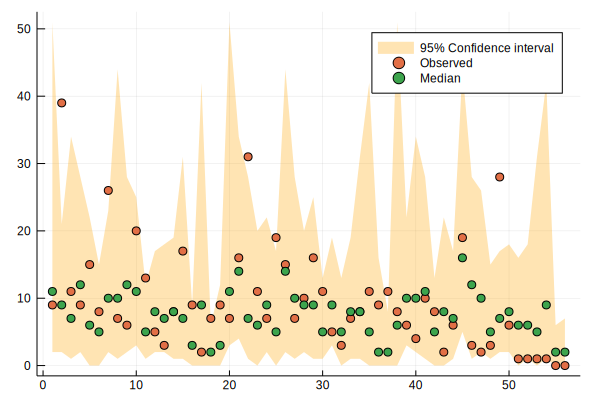

In [22]:
Plots.plot(1:N, sim_quantile[1, :], lw = 0, 
    fillrange = sim_quantile[3, :],
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
scatter!(1:N, observed, label = "Observed")
scatter!(1:N, sim_quantile[2, :], label = "Median")